# Hello :)

Code developed by:

Carmel Natasha Barnabas

Allysa Amani binti Kamardin

Code has been adapted from DeepCharts on GitHub (https://github.com/deepcharts/projects/blob/main/Technical_Indicators_For_Machine_Learning.ipynb)

Note:

If you run into issues with pandas_ta:

Install it

!pip install -U git+https://github.com/twopirllc/pandas-ta

Restart the runtime

In [ ]:
! pip install -U git+https://github.com/twopirllc/pandas-ta

In [1]:
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Data Preparation
1. Getting the Data
2. Shifting columns; 1-day trading lag shift
3. Adding technical indicators
4. Dropping NaNs in rows


In [31]:
# getting the data

full_df = yf.download('^SPX', start="2004-01-01", end="2024-12-31")
full_df = full_df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [32]:
def add_shifted_columns(df_temp):
    df_temp['Previous_Close'] = df_temp['Close'].shift(1) # Prev Day Close Feature
    df_temp['Close_Shifted'] = df_temp['Close'].shift(1) # Prev Day Close Feature
    df_temp['Open_Shifted'] = df_temp['Open'].shift(1)
    df_temp['High_Shifted'] = df_temp['High'].shift(1)
    df_temp['Low_Shifted'] = df_temp['Low'].shift(1)
    return df_temp

def add_indicators(df_temp):
    df_temp = add_shifted_columns(df_temp)
    # Simple Moving Average (SMA): Avg price over last 50 periods
    df_temp['SMA_50'] = ta.sma(df_temp['Close_Shifted'], length=50)

    # Exponential Moving Average (EMA): Weighted average that reacts faster to recent price changes, using 50 periods
    df_temp['EMA_50'] = ta.ema(df_temp['Close_Shifted'], length=50)

    # Relative Strength Index (RSI) : Momentum Indicator that measures the magnitude of recent price changes to evaluate overbought/sold conditions
    df_temp['RSI'] = ta.rsi(df_temp['Close_Shifted'], length=14)

    # Moving Average Convergence Divergence (MACD) : Trend-following momentum indicator: using 12 and 26 periods for fast and slow EMAs and 9-period signal
    macd = ta.macd(df_temp['Close_Shifted'], fast = 12, slow = 26, signal = 9)
    df_temp['MACD'] = macd['MACD_12_26_9']
    df_temp['Signal_Line'] = macd['MACDs_12_26_9']

    # Bollinger Bands: Volatility indicator using a 20-period moving average and 2 standard deviations
    bollinger = ta.bbands(df_temp['Close_Shifted'], length=20, std=2)
    df_temp['Upper_Band'] = bollinger['BBU_20_2.0']
    df_temp['Middle_Band'] = bollinger['BBU_20_2.0']
    df_temp['Lower_Band'] = bollinger['BBL_20_2.0']

    # Stochastic Oscillator: Momentum indicator comparing closing pricess to price ranges over 14 periods with a 3-period %D moving average
    stoch = ta.stoch(df_temp['High_Shifted'], df_temp['Low_Shifted'], df_temp['Close_Shifted'], k=14, d=3)
    df_temp['Stoch_K'] = stoch['STOCHk_14_3_3']
    df_temp['Stoch_D'] = stoch['STOCHd_14_3_3']

    # Average True Range (ATR): Measures volatility by averaging true ranges over 14 periods
    df_temp['ATR'] = ta.atr(df_temp['High_Shifted'], df_temp['Low_Shifted'], df_temp['Close_Shifted'], length=14)

    return df_temp.dropna()

# Apply to all sets
full_df= add_indicators(full_df)
full_df = full_df.dropna()

# splitting dataset
df = full_df[full_df.index < "2015-01-01"]
df_val = full_df[(full_df.index >= "2015-01-01") & (full_df.index < "2021-01-01")]
df_test = full_df[full_df.index >= "2021-01-01"]

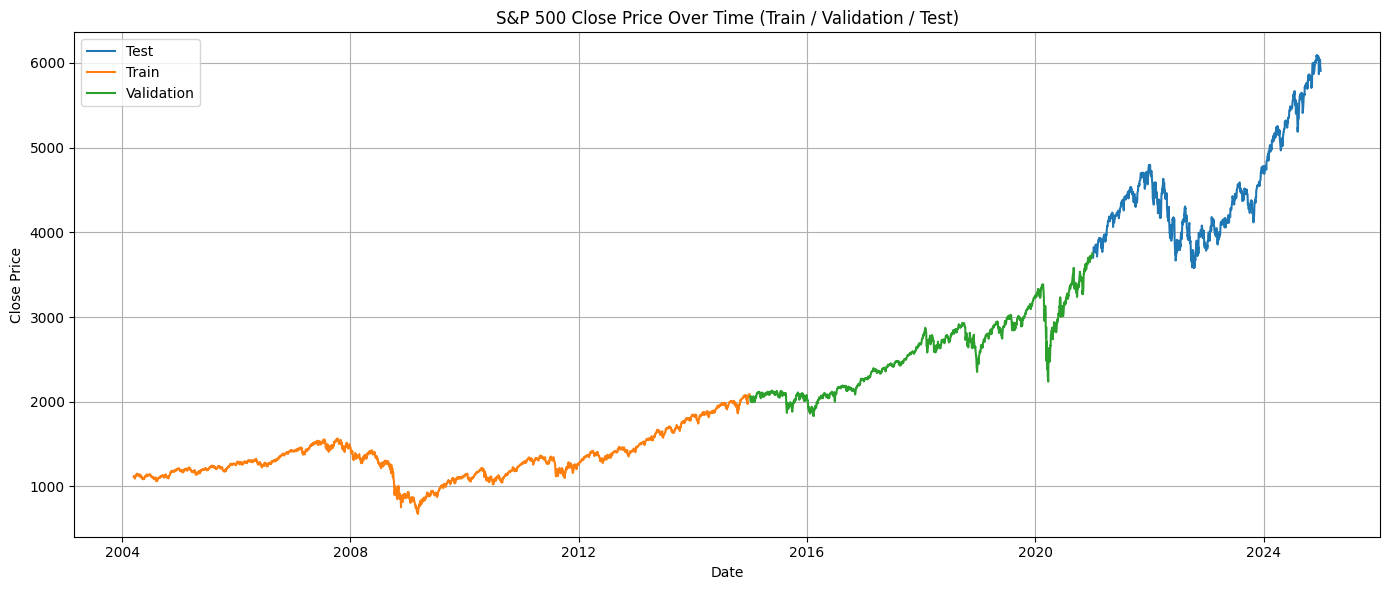

In [33]:
import matplotlib.pyplot as plt

def plot_actual_close_prices(df_train, df_val, df_test):
    # Combine the three datasets
    df_train = df_train.copy()
    df_val = df_val.copy()
    df_test = df_test.copy()

    df_train['Set'] = 'Train'
    df_val['Set'] = 'Validation'
    df_test['Set'] = 'Test'

    full_df = pd.concat([df_train, df_val, df_test])

    # Plot
    plt.figure(figsize=(14, 6))
    for label, group in full_df.groupby('Set'):
        plt.plot(group.index, group['Close'], label=label)

    plt.title("S&P 500 Close Price Over Time (Train / Validation / Test)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_close_prices(df, df_val, df_test)

# Preparing for Modelling

In [65]:
# parameters
window_size = 20 # 4 weeks of trading days (5 weekdays per week * 4 weeks = 20)

# inclusive of indicators as well as the previous day's closing price
# this provides insight as to the impact of the technical indicators has on the price
indicators = ['SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR', 'Close_Shifted', 'Previous_Close']

# initializing a dictionary to store predictions, actual and daily MAE
results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': []} for indicator in indicators}

# Flatten MultiIndex column headers, keeping only the first level (e.g., 'SMA_50')

def flatten_column(df):
  if isinstance(df.columns, pd.MultiIndex):
      df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

print(f"Train data length: {len(df)}")
print(f"Validation data length: {len(df_val)}")
print(f"Test data length: {len(df_test)}")

flatten_column(df)
flatten_column(df_val)
flatten_column(df_test)

print(df.columns.tolist())
print(df_val.columns.tolist())
print(df_test.columns.tolist())


Train data length: 2719
Validation data length: 1511
Test data length: 1004
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR', 'Sentiment']
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR', 'Sentiment']
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR', 'Sentiment']


# The Model

In [83]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# predicting the actual close price by a rolling 4 weeks windows, set by window_size

# The model is trained from scratch every day using only the previous 4 weeks of data.
# Each prediction is for the next unseen day, so it's a form of out-of-sample testing.
# This simulates a realistic trading/investment scenario, where you always train on past data and predict the future.
# Ideal for time-series forecasting.

print(f"Train data length: {len(df)}")
print(f"Validation data length: {len(df_val)}")
print(f"Test data length: {len(df_test)}")


def normalize_features(train_df, val_df, test_df, features):
    scaler = MinMaxScaler()
    train_scaled = train_df.copy()
    val_scaled = val_df.copy()
    test_scaled = test_df.copy()

    # Fit only on training data
    scaler.fit(train_df[features])

    # Transform all sets
    train_scaled[features] = scaler.transform(train_df[features])
    val_scaled[features] = scaler.transform(val_df[features])
    test_scaled[features] = scaler.transform(test_df[features])

    return train_scaled, val_scaled, test_scaled


def rolling_prediction(df_segment, window_size, indicators):
    results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': []}
           for indicator in indicators if indicator != 'Previous_Close'}

    for indicator in indicators:
        for i in range(window_size, len(df_segment) - 1):
            train_df = df_segment.iloc[i - window_size:i]
            test_index = i + 1

            if test_index >= len(df_segment):
                break

            X_train = train_df[[indicator, 'Previous_Close']]
            y_train = train_df['Close']

            X_train = sm.add_constant(X_train, has_constant='add')


            #model = sm.OLS(y_train, X_train).fit()

            # Train Random Forest model
            model = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=5)
            model.fit(X_train, y_train)

            print("X_train column:", X_train.columns)

            train_mae = mean_absolute_error(y_train, model.predict(X_train))
            results[indicator]['train_mae'].append(train_mae)

            X_test = df_segment[[indicator, 'Previous_Close']].iloc[[test_index]]
            X_test = sm.add_constant(X_test, has_constant='add')
            prediction = model.predict(X_test)[0]


            print("X_test column:", X_test.columns)
            actual = df_segment['Close'].iloc[test_index]

            results[indicator]['predictions'].append(prediction)
            results[indicator]['actual'].append(actual)
            results[indicator]['daily_mae'].append(abs(actual - prediction))

    return results


# Normalize features
# df_norm, df_val_norm, df_test_norm = normalize_features(df, df_val, df_test, indicators)

#train_results = rolling_prediction(df_norm, window_size=20, indicators=indicators)
#val_results = rolling_prediction(df_val_norm, window_size=20, indicators=indicators)
#test_results = rolling_prediction(df_test_norm, window_size=20, indicators=indicators)

# Check the final results after running the function
#print("Train Results:", train_results)
#print("Val Results:", val_results)
#print("Test Results:", test_results)

Train data length: 2719
Validation data length: 1511
Test data length: 1004


In [ ]:
# This section is for seeing the output in for just stock predictiton without sentiment analysis.
# Uncomment the code if you wish to see this.
'''
import numpy as np
# Validation Results
print("Validation Results")
print("Indicator\tTrain MAE\tVal MAE")
for indicator in indicators[:-1]:  # Exclude 'Previous_Close'-only case
    avg_train_mae = np.mean(val_results[indicator]['train_mae'])
    avg_val_mae = np.mean(val_results[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_val_mae:.4f}")

print("\n" + "="*50 + "\n")

# Test Results
print("Test Results")
print("Indicator\tTrain MAE\tTest MAE")
for indicator in indicators[:-1]:
    avg_train_mae = np.mean(test_results[indicator]['train_mae'])
    avg_test_mae = np.mean(test_results[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_test_mae:.4f}")

'''

Top 3 indicators by validation MAE: ['Close_Shifted', 'RSI', 'SMA_50']


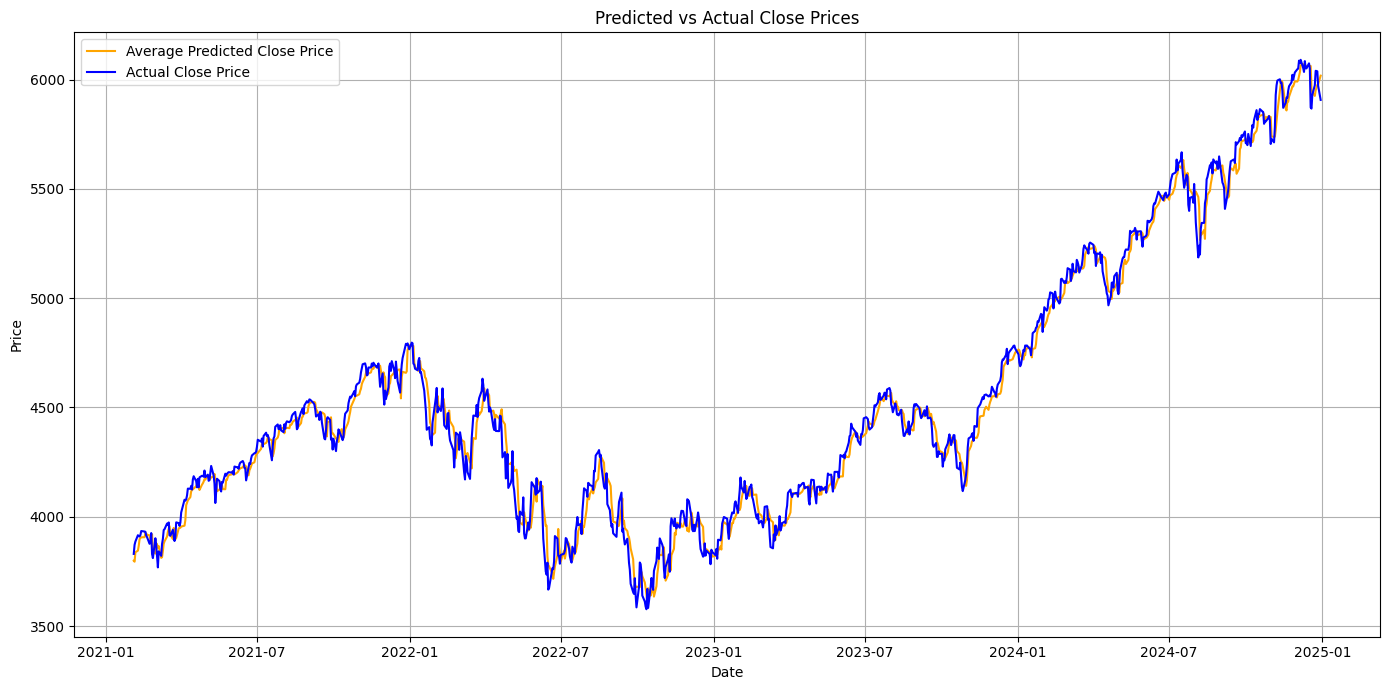

In [71]:
# seeing results for stock prediction without sentiment analysis
import matplotlib.pyplot as plt

# Compute average prediction across all indicators (excluding 'Previous_Close')
avg_preds = []
actual_prices = []

# Step 1: Find the top 3 indicators with the lowest validation MAE
mae_scores = {}

for ind in indicators[:-1]:  # Exclude 'Previous_Close'
    preds = test_results[ind]['predictions']
    actuals = test_results[ind]['actual']
    mae = mean_absolute_error(actuals, preds)
    mae_scores[ind] = mae

# Sort indicators by MAE and pick the best 3
top_3_indicators = sorted(mae_scores, key=mae_scores.get)[:3]

print("Top 3 indicators by validation MAE:", top_3_indicators)

# Step 2: Now average only the top 3 indicators
num_preds = len(test_results[top_3_indicators[0]]['predictions'])  # They all have the same number

for i in range(num_preds):
    preds = [test_results[ind]['predictions'][i] for ind in top_3_indicators]
    avg_preds.append(np.mean(preds))  # Average of top 3 predictions
    actual_prices.append(test_results[top_3_indicators[0]]['actual'][i])  # Same actual for all

# Create the timeline for the test period
# The test predictions start at index (window_size + 1)
test_dates = df_test.index[window_size + 1: window_size + 1 + num_preds]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(test_dates, avg_preds, label='Average Predicted Close Price', color='orange')
plt.plot(test_dates, actual_prices, label='Actual Close Price', color='blue')
plt.title("Predicted vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Stock Sentiment Analysis

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Load both CSV files
csv_file1 = "/content/drive/MyDrive/FYP/sp500_news_290k_articles.csv"  # original
csv_file2 = "/content/drive/MyDrive/FYP/stock_data_articles.csv"  # the new one

df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)

# Standardize df2 to match df1 format
df2 = df2.rename(columns={
    'symbol': 'ticker',
    'Publishdate': 'date',
    'Title': 'headline'
})
df2['time'] = None  # no time info available in new news
df2 = df2[['ticker', 'date', 'headline', 'time']]  # keep only these columns

# Combine the two dataframes
df = pd.concat([df1[['ticker', 'date', 'headline', 'time']], df2], ignore_index=True)

# Your keyword list
keyword_list = ['Apple', 'Microsoft', 'Nvidia', 'Amazon', 'Meta', 'Berkshire', 'Google', 'Alphabet Inc.', 'Broadcom Inc.', 'Tesla', 'GSPC', 'SPY', 'SPX']


total_score = 0
num_articles = 0

for idx, row in df.iterrows():
    headline = str(row['headline'])  # Just in case of missing data
    ticker = str(row['ticker'])

    # Check if any keyword matches in the headline
    if not any(keyword.lower() in headline.lower() for keyword in keyword_list):
        continue

    print(f'Ticker: {ticker}')
    print(f'Headline: {headline}')
    print(f'Date: {row["date"]} {row["time"]}')

    # Run sentiment analysis
    sentiment = pipe(headline)[0]

    print(f'Sentiment {sentiment["label"]}, Score {sentiment["score"]}')
    print('-' * 40)

    if sentiment['label'].lower() == 'positive':
        total_score += sentiment['score']
        num_articles += 1
    elif sentiment['label'].lower() == 'negative':
        total_score -= sentiment['score']
        num_articles += 1

# Final sentiment score
final_score = total_score / num_articles if num_articles > 0 else 0
print(f'Final Sentiment Score: {final_score}')
print(f'Overall Sentiment: {"Positive" if final_score >= 0.15 else "Negative" if final_score <= -0.15 else "Neutral"} {final_score}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ADD SENTIMENT SCORE as a constant feature
df['Sentiment'] = final_score
df_val['Sentiment'] = final_score
df_test['Sentiment'] = final_score

# New indicators list = top 3 + 'Sentiment'
selected_indicators = top_3_indicators + ['Sentiment']

print(selected_indicators)

# Normalize again (only selected indicators)
df_norm, df_val_norm, df_test_norm = normalize_features(df, df_val, df_test, selected_indicators)

#note:: in rolling_prediction(), it has this line "for indicator in indicators[:-1]:"
# this will exclude the last element because its meant to account for 'Previous_Close' when training without SA
# when running for SA, it needs to be "for indicator in indicators:" to ensure it accounts for all indicators, incl Sentiment

# Re-run rolling prediction ONLY on top 3 + Sentiment
train_results = rolling_prediction(df_norm, window_size=20, indicators=selected_indicators)
val_results = rolling_prediction(df_val_norm, window_size=20, indicators=selected_indicators)
test_results = rolling_prediction(df_test_norm, window_size=20, indicators=selected_indicators)

In [86]:
import json

# Prepare predictions for saving
predictions_to_save = {}

# IMPORTANT: use selected_indicators, not full indicators list
for indicator in selected_indicators:
    predictions_to_save[indicator] = {
        'predictions': val_results[indicator]['predictions'],  # Save predictions
        'actual': val_results[indicator]['actual']  # Save ground truth
    }

# Save to a JSON file
with open('val_predictions.json', 'w') as f:
    json.dump(predictions_to_save, f)

print("Validation predictions saved to val_predictions.json!")

Validation predictions saved to val_predictions.json!


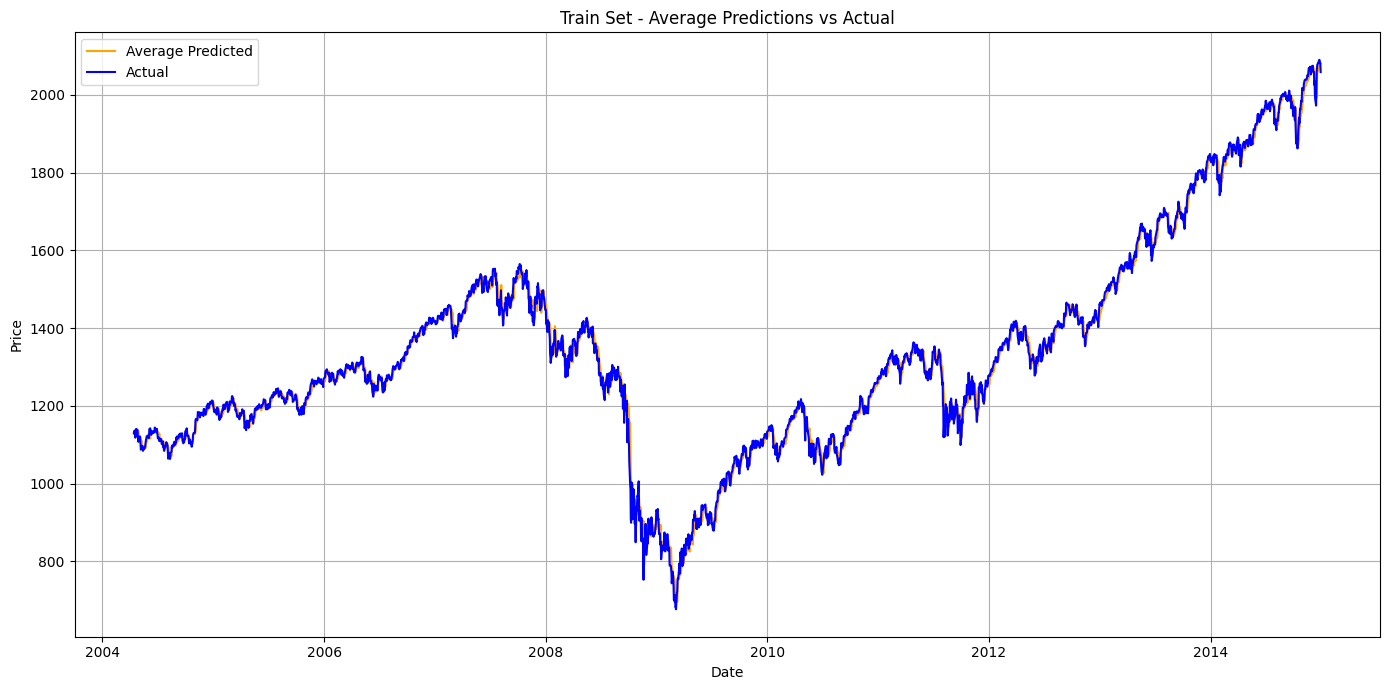

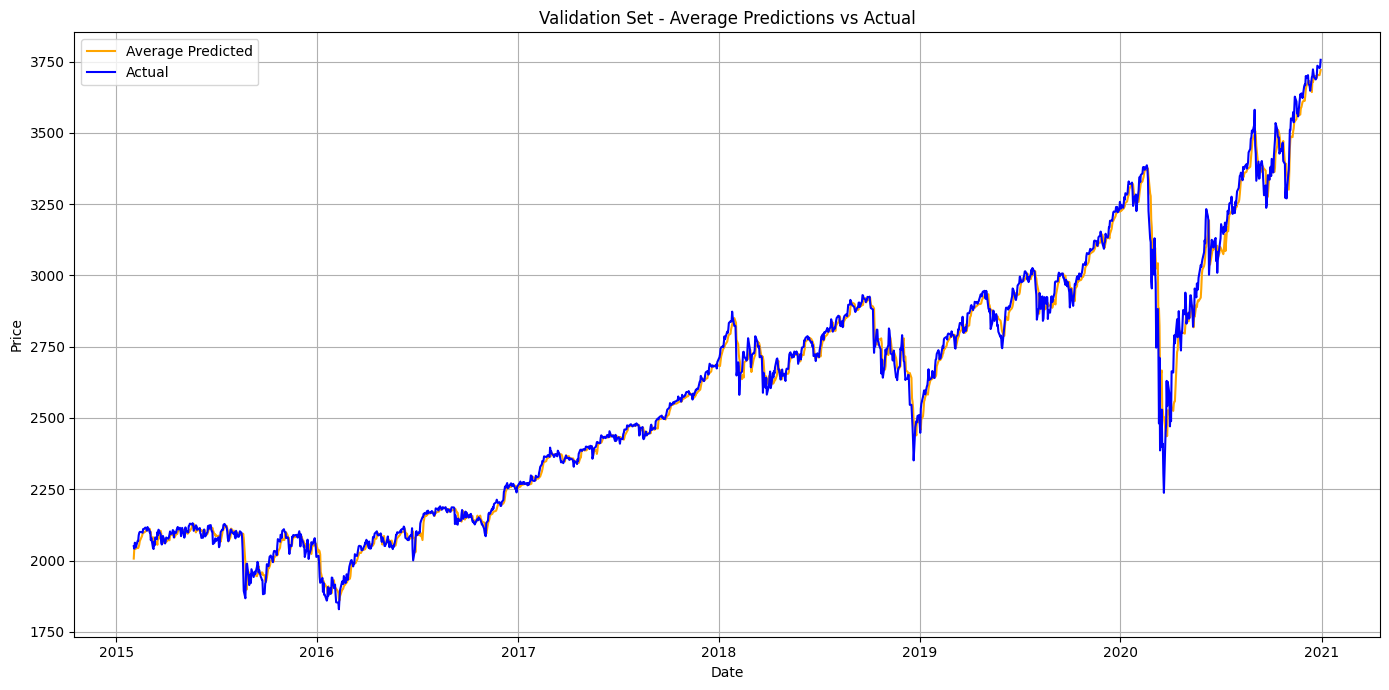

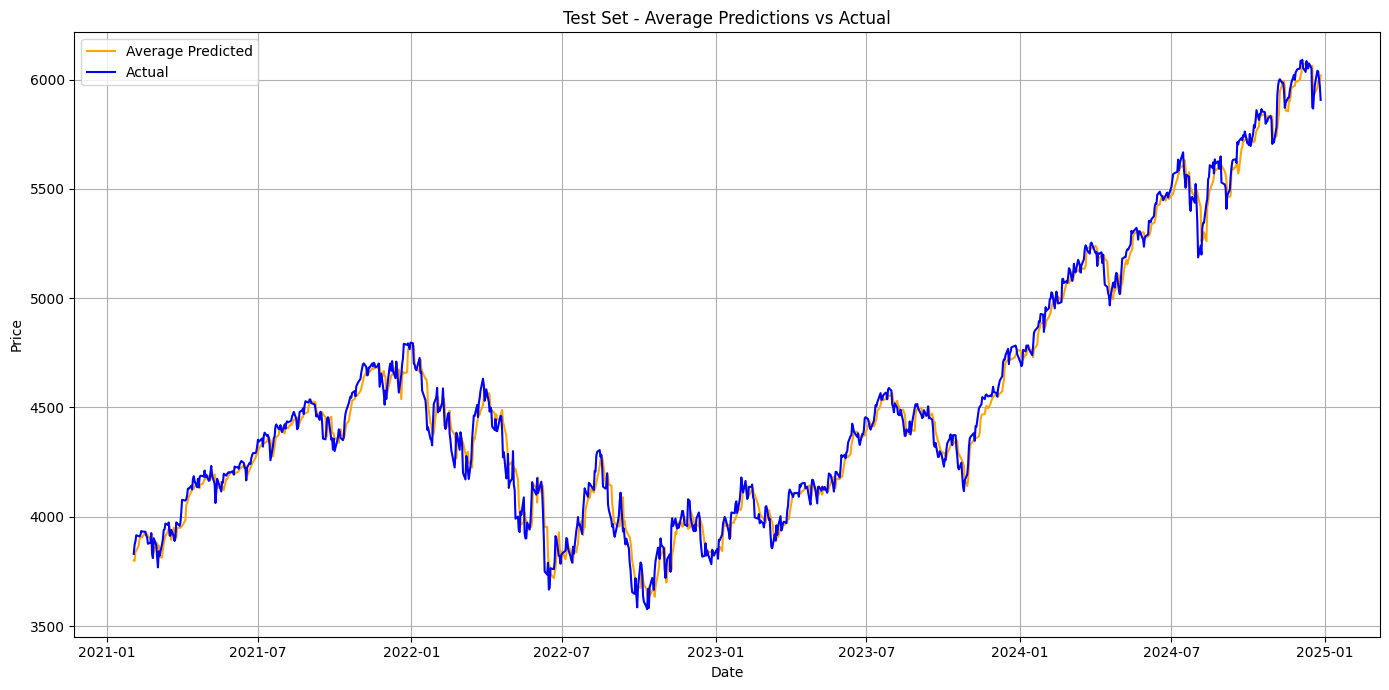

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot predictions vs actual values
def plot_predictions(predictions, actuals, dates, title):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, predictions, label='Average Predicted', color='orange')
    plt.plot(dates, actuals, label='Actual', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 1: Compute the average predictions across the top 3 indicators and Sentiment
def average_predictions(results, top_3_indicators, sentiment='Sentiment'):
    avg_preds = []
    actual_prices = []

    # Get the number of predictions (they should all be the same length)
    num_preds = len(results[top_3_indicators[0]]['predictions'])

    for i in range(num_preds):
        # Get the predictions for each of the top 3 indicators + Sentiment
        preds = [results[indicator]['predictions'][i] for indicator in top_3_indicators]  # Top 3 indicators
        preds.append(results[sentiment]['predictions'][i])  # Add Sentiment

        # Average the predictions
        avg_preds.append(np.mean(preds))  # Average of top 3 predictions + Sentiment

        # Use the actual price from the first indicator (same for all indicators)
        actual_prices.append(results[top_3_indicators[0]]['actual'][i])

    return avg_preds, actual_prices

# Step 2: Get average predictions for each dataset (train, val, test)
train_avg_preds, train_actuals = average_predictions(train_results, top_3_indicators)
val_avg_preds, val_actuals = average_predictions(val_results, top_3_indicators)
test_avg_preds, test_actuals = average_predictions(test_results, top_3_indicators)

# Step 3: Create date ranges for plotting (same length as the predictions)
train_dates = df.index[20:20 + len(train_avg_preds)]
val_dates = df_val.index[20:20 + len(val_avg_preds)]
test_dates = df_test.index[20:20 + len(test_avg_preds)]

# Step 4: Plot the results
plot_predictions(train_avg_preds, train_actuals, train_dates, title="Train Set - Average Predictions vs Actual")
plot_predictions(val_avg_preds, val_actuals, val_dates, title="Validation Set - Average Predictions vs Actual")
plot_predictions(test_avg_preds, test_actuals, test_dates, title="Test Set - Average Predictions vs Actual")


Validation Results
Indicator	Train MAE	Val MAE
Close_Shifted  	13.1096		25.9935
RSI            	12.2484		26.7873
SMA_50         	11.0870		27.2052
Sentiment      	13.1096		25.9935


Test Results
Indicator	Train MAE	Test MAE
Close_Shifted  	24.3821		47.9736
RSI            	22.8047		50.3529
SMA_50         	20.1419		51.9832
Sentiment      	24.3821		47.9736


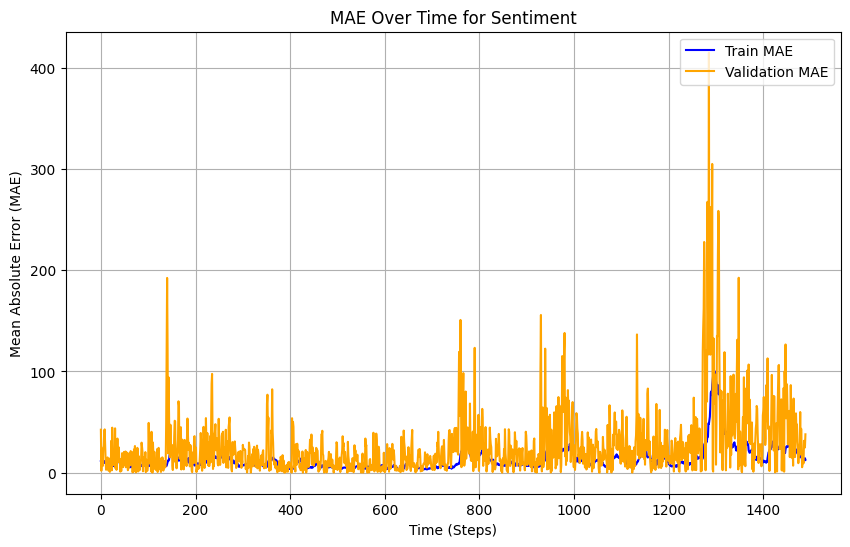

In [90]:
# Results reporting for top_3_indicators and Sentiment
print("Validation Results")
print("Indicator\tTrain MAE\tVal MAE")
for indicator in selected_indicators:
    avg_train_mae = np.mean(val_results[indicator]['train_mae'])
    avg_val_mae = np.mean(val_results[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_val_mae:.4f}")

print("\n" + "="*50 + "\n")

print("Test Results")
print("Indicator\tTrain MAE\tTest MAE")
for indicator in selected_indicators:
    avg_train_mae = np.mean(test_results[indicator]['train_mae'])
    avg_test_mae = np.mean(test_results[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_test_mae:.4f}")

# Plotting MAE over time (for each indicator and sentiment)
plt.figure(figsize=(10, 6))

# Plot training MAE over time
plt.plot(val_results[indicator]['train_mae'], label="Train MAE", color='blue', linestyle='-')

# Plot validation MAE over time
plt.plot(val_results[indicator]['daily_mae'], label="Validation MAE", color='orange', linestyle='-')

# Adding titles and labels
plt.title(f'MAE Over Time for {indicator}')
plt.xlabel('Time (Steps)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(loc='upper right')

# Show grid for better readability
plt.grid(True)

# Show the plot
plt.show()


# Trading Bot

In [120]:
# initializing agents
# Initial parameters
initial_balance = 200000  # Starting balance in USD
num_agents = 3  # Number of agents

# Define agent strategies
agents = []

# Greedy Buyer Agent
greedy_buyer = {
    'balance': initial_balance,
    'shares_owned': 0,
    'trade_history': [],
    'risk_per_trade': 0.02,  # 2% risk
    'stop_loss_pct': 0.05,   # 5% stop-loss
    'take_profit_pct': 0.05, # 5% take-profit
    'strategy': 'Greedy Buyer'
}
agents.append(greedy_buyer)

# Cautious Investor Agent
cautious_investor = {
    'balance': initial_balance,
    'shares_owned': 0,
    'trade_history': [],
    'risk_per_trade': 0.015,  # 1.5% risk
    'stop_loss_pct': 0.03,    # 3% stop-loss
    'take_profit_pct': 0.04,  # 4% take-profit
    'strategy': 'Cautious Investor'
}
agents.append(cautious_investor)

# Contrarian Trader Agent
contrarian_trader = {
    'balance': initial_balance,
    'shares_owned': 0,
    'trade_history': [],
    'risk_per_trade': 0.02,  # 2% risk
    'stop_loss_pct': 0.06,   # 6% stop-loss
    'take_profit_pct': 0.05, # 5% take-profit
    'strategy': 'Contrarian Trader'
}
agents.append(contrarian_trader)

# Re-initialize cumulative_balances
cumulative_balances = {agent['strategy']: [] for agent in agents}

In [ ]:
predicted_prices = test_avg_preds  # Already your model output

# Trading loop for each agent
for i in range(1, len(test_avg_preds)):
    current_price = predicted_prices[i]
    previous_price = predicted_prices[i-1]

        # Print for debugging
    print(f"current_price: {current_price}, previous_price: {previous_price}")

    # Process each agent's trades
    for agent in agents:
        balance = agent['balance']
        shares_owned = agent['shares_owned']
        risk_per_trade = agent['risk_per_trade']
        stop_loss_pct = agent['stop_loss_pct']
        take_profit_pct = agent['take_profit_pct']
        trade_history = agent['trade_history']
        strategy = agent['strategy']

        # Track cumulative balance for plotting
        cumulative_balance = balance + (shares_owned * current_price)  # Portfolio value

        # Initialize cumulative_balances dictionary if it doesn't exist
        if strategy not in cumulative_balances:
            cumulative_balances[strategy] = []

        # Add cumulative balance to the list for this agent
        cumulative_balances[strategy].append(cumulative_balance)


        # Determine the amount of capital to risk per trade for this agent
        risk_capital = balance * risk_per_trade

        # --- Strategy: Greedy Buyer ---
        if strategy == 'Greedy Buyer':
            # Buy when price is rising
            if current_price > previous_price and balance >= current_price:
                shares_to_buy = risk_capital // current_price
                if shares_to_buy == 0:
                    continue

                balance -= shares_to_buy * current_price
                shares_owned += shares_to_buy

                # Calculate stop-loss and take-profit levels
                stop_loss = current_price * (1 - stop_loss_pct)
                take_profit = current_price * (1 + take_profit_pct)

                trade_history.append(f"Greedy Buyer BUY {shares_to_buy} at {current_price}, Stop-Loss: {stop_loss}, Take-Profit: {take_profit}")

            # Sell if price drops (quick profit-taking)
            elif current_price < previous_price and shares_owned > 0:
                balance += shares_owned * current_price
                trade_history.append(f"Greedy Buyer SELL {shares_owned} at {current_price}")
                shares_owned = 0

        # --- Strategy: Cautious Investor ---
        if strategy == 'Cautious Investor':
            # Only buy if price has increased for 3 consecutive days
            if current_price > previous_price and (avg_preds[i-1] > avg_preds[i-2]):
                if balance >= current_price:
                    shares_to_buy = risk_capital // current_price
                    if shares_to_buy == 0:
                        continue

                    balance -= shares_to_buy * current_price
                    shares_owned += shares_to_buy

                    # Calculate stop-loss and take-profit levels
                    stop_loss = current_price * (1 - stop_loss_pct)
                    take_profit = current_price * (1 + take_profit_pct)

                    trade_history.append(f"Cautious Investor BUY {shares_to_buy} at {current_price}, Stop-Loss: {stop_loss}, Take-Profit: {take_profit}")

            # Sell if price decreases (cutting losses early)
            elif current_price < previous_price and shares_owned > 0:
                balance += shares_owned * current_price
                trade_history.append(f"Cautious Investor SELL {shares_owned} at {current_price}")
                shares_owned = 0

        # --- Strategy: Contrarian Trader ---
        if strategy == 'Contrarian Trader':
            # Buy when price is falling (expecting reversal)
            if current_price < previous_price and balance >= current_price:
                shares_to_buy = risk_capital // current_price
                if shares_to_buy == 0:
                    continue

                balance -= shares_to_buy * current_price
                shares_owned += shares_to_buy

                # Calculate stop-loss and take-profit levels
                stop_loss = current_price * (1 - stop_loss_pct)
                take_profit = current_price * (1 + take_profit_pct)

                trade_history.append(f"Contrarian Trader BUY {shares_to_buy} at {current_price}, Stop-Loss: {stop_loss}, Take-Profit: {take_profit}")

            # Sell when price is rising (expecting correction)
            elif current_price > previous_price and shares_owned > 0:
                balance += shares_owned * current_price
                trade_history.append(f"Contrarian Trader SELL {shares_owned} at {current_price}")
                shares_owned = 0

        # Update agent's information
        agent['balance'] = balance
        agent['shares_owned'] = shares_owned

# After the loop, check the final balance (after selling all shares) for each agent
for agent_id, agent in enumerate(agents):
    final_balance = agent['balance'] + (agent['shares_owned'] * full_df['Close'].iloc[-1])  # Add the value of remaining shares
    print(f"Agent {agent_id+1} ({agent['strategy']}) Final Balance: {final_balance}")
    print(f"Agent {agent_id+1} Trade History:", agent['trade_history'])

In [ ]:
# Plotting the cumulative performance of each agent
plt.figure(figsize=(12, 6))

# Ensure that the number of time steps matches the length of cumulative_balances
time_steps = range(1, len(cumulative_balances[next(iter(cumulative_balances))]) + 1)

# Plot the cumulative balance for each agent's strategy
for agent in agents:
    strategy = agent['strategy']
    plt.plot(time_steps, cumulative_balances[strategy], label=strategy)

plt.title('Performance Comparison of Trading Agents')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Portfolio Value (USD)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
